Testar Haiku e CNNs

Datasets:
- MNIST
- CIFAR100

Coisas a testar:
- BatchNorm
- Arquiteturas mais modernas
    - Testar um transformer? hehe => só depois de já estar rodando uma CNN bacana
- Inicialização dos pesos

In [1]:
!pip install dm-haiku

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 9.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import jax
import jax.numpy as jnp
import haiku as hk
import optax

from keras.datasets import mnist, cifar100

import functools
import matplotlib.pyplot as plt

# Dataset

In [14]:
def gen_one_hot_y(y, num_classes):
    one_hot_y = np.zeros((len(y), num_classes))
    for i in range(len(y)):
        one_hot_y[i, y[i]] = 1
    return one_hot_y

# Shuffle the training dataset
def unison_shuffled_copies(a, b):
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [15]:
# (train_X, train_y), (test_X, test_y) = mnist.load_data()
(train_X, train_y), (test_X, test_y) = cifar100.load_data(label_mode="fine")
num_classes = 100

In [16]:
train_X, train_y = unison_shuffled_copies(train_X, train_y)

In [17]:
train_one_hot_y = gen_one_hot_y(train_y, num_classes)
test_one_hot_y = gen_one_hot_y(test_y, num_classes)

In [18]:
# Normalize and add channel dim
train_X = train_X / 255.0
# train_X = np.expand_dims(train_X, axis=3)

test_X = test_X / 255.0
# test_X = np.expand_dims(test_X, axis=3)

In [19]:
train_X.shape

(50000, 32, 32, 3)

[63] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


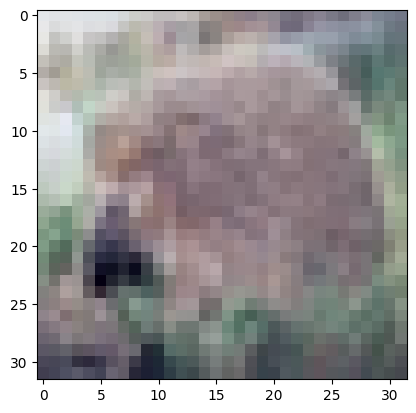

In [22]:
i = 145
print(train_y[i], train_one_hot_y[i])
plt.imshow(train_X[i])

# Networks

In [23]:
def cross_entropy_loss(logits, labels):
    """
    Args:
        logits: Unnormalized log probabilities, with shape `[..., num_classes]`.
        labels: Valid probability distributions (non-negative, sum to 1), e.g a
            one hot encoding specifying the correct class for each input;
            must have a shape broadcastable to `[..., num_classes]`.
    Returns:
        cross entropy between each prediction and the corresponding target
        distributions, with shape `[...]`.
    """
    return -jnp.sum(labels * jax.nn.log_softmax(logits, axis=-1), axis=-1)

def loss_fn(model, params, batch, rng):
    # batch = {'x': input_batch, 'label': one_hot}
    logits = model(params=params, rng=rng, x=batch['x'])
    return jnp.sum(cross_entropy_loss(logits, batch['label']))

In [24]:
# Training, in a class to handle jitting better
class SGDLearner():
    def __init__(self, model, loss_fn, optimizer, random_key, dummy_x):
        self.model = model
        self._model_with_loss = functools.partial(loss_fn, model.apply)

        def sgd_step_fun(state, batch):
            """
            state = {'params', 'opt_state', 'rng_key'}
            Returns: state, extra
            """
            # Run gradient step
            extra = {}
            next_rng_key, rng_key = jax.random.split(state['rng_key'])
            loss, grads = jax.value_and_grad(self._model_with_loss)(state['params'], batch, rng_key)
            extra['loss'] = loss
            # Apply the optimizer updates
            updates, new_opt_state = optimizer.update(grads, state['opt_state'])
            new_params = optax.apply_updates(state['params'], updates)
            new_state = {'params':new_params, 'opt_state':new_opt_state, 'rng_key':next_rng_key}
            return new_state, extra
        self._sgd_step = jax.jit(sgd_step_fun)

        # Initialize the network parameters
        key_params, key_state = jax.random.split(random_key, 2)
        initial_params = self.model.init(rng=key_params, x=dummy_x)
        self._state = {
            'params': initial_params,
            'opt_state': optimizer.init(initial_params),
            'rng_key': key_state
        }
    
    def step(self, batch):
        self._state, extra = self._sgd_step(self._state, batch)
        return extra

    def get_params(self):
        return self._state['params']

    def save(self):
        return self._state

    def restore(self, state):
        self._state = state

In [25]:
def eval_loss_acc_fn(model, params, batch, rng):
    extra = {}
    logits = model(params=params, rng=rng, x=batch['x'])
    extra['loss'] = jnp.sum(cross_entropy_loss(logits, batch['label']))
    preds = jnp.argmax(logits, axis=1)
    labels = jnp.argmax(batch['label'], axis=1)
    extra['hits'] = jnp.sum(preds == labels)
    return extra

class Evaluator():
    def __init__(self, model, eval_fn, random_key):
        self.model = model
        self._model_eval = jax.jit(functools.partial(eval_fn, model.apply))
        self.rng = random_key
    
    def evaluate(self, params, batch):
        return self._model_eval(params, batch, self.rng)


In [26]:
# Train loop
def train_loop(X, y, batch_sz, learner):
    total_loss = 0.0
    X_len = len(y)
    for i in range(1 + X_len//batch_sz):
        low_i = i*batch_sz
        high_i = min((i+1)*batch_sz, X_len)
        if low_i >= X_len: break
        batch = {'x': X[low_i: high_i], 'label': y[low_i: high_i]}
        extra = learner.step(batch)
        total_loss += extra['loss']
    return {'mean_loss':total_loss/X_len}

# Eval Loop => also get accuracy => another jit function
def eval_loop(X, y, batch_sz, evaluator, params):
    total_loss = 0.0
    hits = 0.0
    X_len = len(y)
    for i in range(1 + X_len//batch_sz):
        low_i = i*batch_sz
        high_i = min((i+1)*batch_sz, X_len)
        if low_i >= X_len: break
        batch = {'x': X[low_i: high_i], 'label': y[low_i: high_i]}
        extra = evaluator.evaluate(params, batch)
        total_loss += extra['loss']
        hits += extra['hits']
    return {'mean_loss':total_loss/X_len, 'accuracy':hits/X_len}

In [32]:
class LeNet5(hk.Module):
    def __init__(self, output_sz, name=None):
        super().__init__(name=name)
        self.output_sz = output_sz

    def __call__(self, x):
        network = hk.Sequential([
            hk.Conv2D(output_channels=6, kernel_shape=[4, 4], stride=1, padding='VALID'),
            jax.nn.relu,
            hk.MaxPool(window_shape=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'),
            hk.Conv2D(output_channels=16, kernel_shape=[4, 4], stride=1, padding='VALID'),
            jax.nn.relu,
            hk.MaxPool(window_shape=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME'),
            hk.Flatten(),
            hk.Linear(120),
            jax.nn.relu,
            hk.Linear(84),
            jax.nn.relu,
            hk.Linear(self.output_sz)
        ])
        return network(x)

def _LeNet5_fun(x):
    module = LeNet5(num_classes)
    return module(x)

model = hk.transform(_LeNet5_fun)

In [33]:
dummy_x = jnp.ones(shape=(2, train_X.shape[1], train_X.shape[2], train_X.shape[3]))
rng_key = jax.random.PRNGKey(42)

grad_clip_value = np.inf
learning_rate = 1e-3
batch_sz = 128

optimizer = optax.chain(
        optax.clip_by_global_norm(grad_clip_value),
        optax.adam(learning_rate, b1=0.9, b2=0.99))

learner = SGDLearner(model, loss_fn, optimizer, rng_key, dummy_x)
evaluator = Evaluator(model, eval_loss_acc_fn, rng_key)

train_loss_l = []
val_loss_l = []
val_acc_l = []

In [34]:
n_epochs = 5
last_epoch = 0

In [ ]:
for epoch_i in range(last_epoch, n_epochs+last_epoch):
    train_extra = train_loop(train_X, train_one_hot_y, batch_sz, learner)
    val_extra = eval_loop(test_X, test_one_hot_y, batch_sz, evaluator, learner.get_params())
    
    print(f'Epoch {epoch_i}: \n\t Train loss: {train_extra["mean_loss"]}')
    print(f' Val loss: {val_extra["mean_loss"]} \t Val Acc: {val_extra["accuracy"]}')
    train_loss_l.append(train_extra['mean_loss'])
    val_loss_l.append(val_extra['mean_loss'])
    val_acc_l.append(val_extra['accuracy'])


Final Val Accuracy: 0.985


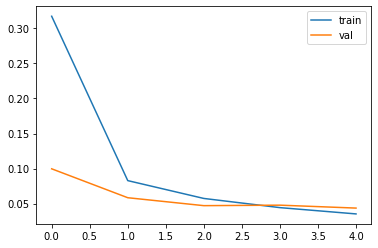

In [27]:
# Plot results
print('Final Val Accuracy: {:.3f}'.format(val_acc_l[-1]))
x = list(range(len(train_loss_l)))
plt.plot(x, train_loss_l, label='train')
plt.plot(x, val_loss_l, label='val')
plt.legend()